Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Unzip Dataset

In [ ]:
!unzip gdrive/My\ Drive/lego_bricks/lego_bricks.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/43857 beam 1x2 300R.png  
  inflating: dataset/43857 beam 1x2 301L.png  
  inflating: dataset/43857 beam 1x2 301R.png  
  inflating: dataset/43857 beam 1x2 302L.png  
  inflating: dataset/43857 beam 1x2 302R.png  
  inflating: dataset/43857 beam 1x2 303L.png  
  inflating: dataset/43857 beam 1x2 303R.png  
  inflating: dataset/43857 beam 1x2 304L.png  
  inflating: dataset/43857 beam 1x2 304R.png  
  inflating: dataset/43857 beam 1x2 305L.png  
  inflating: dataset/43857 beam 1x2 305R.png  
  inflating: dataset/43857 beam 1x2 306L.png  
  inflating: dataset/43857 beam 1x2 306R.png  
  inflating: dataset/43857 beam 1x2 307L.png  
  inflating: dataset/43857 beam 1x2 307R.png  
  inflating: dataset/43857 beam 1x2 308L.png  
  inflating: dataset/43857 beam 1x2 308R.png  
  inflating: dataset/43857 beam 1x2 309L.png  
  inflating: dataset/43857 beam 1x2 309R.png  
  inflating: dataset/43857 beam 1x2 310L.png  
  inflati

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import sys
np.printoptions(threshold=sys.maxsize)

In [ ]:
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from torch import Tensor
import os

class lego(Dataset):

    
    def __init__(self, images, transforms=None, classes=None):
        np.random.shuffle(images)
        self.classes = classes if classes is not None else {}
        self.num_classes = 0 if self.classes is None else len(self.classes)
        self.dataset_x = []
        self.dataset_y = []
        self.transforms = transforms
        
        for name in images:
            temp = name.split()
            self.dataset_x.append(f"{source_dir}{name}")
            image_class = "_".join(temp[1:-1])
                        
            if (image_class not in self.classes):
                self.classes[image_class] = self.num_classes
                self.num_classes += 1
            self.dataset_y.append(self.classes[image_class])
        
    def __getitem__(self, idx):
        image = plt.imread(self.dataset_x[idx])
        if self.transforms is not None:
            image = self.transforms(image)
        return image, self.dataset_y[idx]

    def __len__(self):
        return len(self.dataset_x)

In [ ]:
# Constructing the transforms of the images
import torchvision.transforms as transforms

trans = {
    "train":
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([128, 128]),
#         transforms.Normalize([], [1]),
    ]),

    "eval":
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([128, 128]),
#         transforms.Normalize([0], [1]),
    ])
}

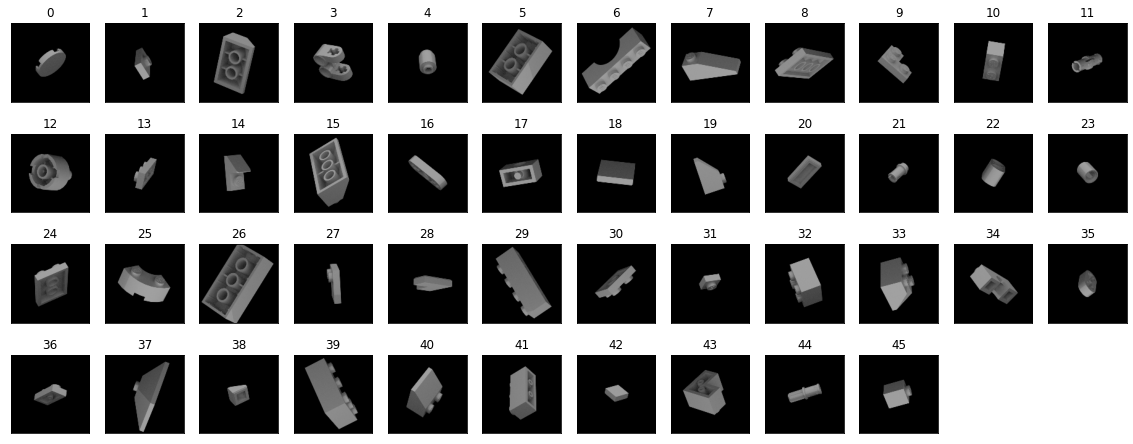

In [ ]:
source_dir="dataset/"
images = os.listdir(source_dir)
train_images, eval_images = images[:int(len(images)*0.8)], images[int(len(images)*0.8):]
train_data = lego(train_images, trans["train"])

plt.figure(figsize=[20, 20])
for i, class_name in enumerate(np.unique(train_data.dataset_y)):
    plt.subplot(10, 12, i+1)
    temp = np.where(train_data.dataset_y == class_name)[0][0]
    plt.imshow(np.swapaxes(train_data[temp][0], 0, -1), cmap="gray"), plt.title(str(class_name)), plt.xticks([]), plt.yticks([])
    
plt.show()

eval_data = lego(eval_images, trans["eval"], classes=train_data.classes)

In [ ]:
def load_names(directory):
    f = []
    for (filenames) in os.walk(directory):
        f.extend(filenames)
        break
    return f
data = pd.DataFrame(load_names(source_dir) [2])

#Let's check:
print(data.shape)
print(data)

(40000, 1)
                                                0
0                          18654 beam 1M 343R.png
1                         3003 brick 2x2 310R.png
2                         43857 beam 1x2 345R.png
3                     3070 Flat Tile 1x1 363L.png
4      3045 roof corner outside tile 2x2 312L.png
...                                           ...
39995                     3623 Plate 1x3 102R.png
39996             2780 Peg with friction 268R.png
39997                     3020 plate 2x4 380R.png
39998                      6632 lever 3M 061R.png
39999                 3659 brick bow 1x4 001L.png

[40000 rows x 1 columns]


In [ ]:
len(train_data), len(eval_data)

(32000, 8000)

In [ ]:
import torch
from torch.cuda import is_available

# get the device
device = torch.device("cuda" if is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from torch.utils.data import DataLoader
from torch import nn 

train_loader = DataLoader(train_data, batch_size=256)
eval_loader = DataLoader(eval_data, batch_size=1024)


# Construct the model
layers = []
layers.append(nn.Conv2d(3, 16, 3, 1, 1))
layers.append(nn.ReLU())
layers.append(nn.MaxPool2d(2, 2))
layers.append(nn.Conv2d(16, 32, 3, 1, 1))
layers.append(nn.BatchNorm2d(32))
layers.append(nn.ReLU())
layers.append(nn.MaxPool2d(2, 2))
layers.append(nn.Conv2d(32, 64, 3, 1, 1))
layers.append(nn.ReLU())
layers.append(nn.BatchNorm2d(64))
layers.append(nn.MaxPool2d(2, 2))
layers.append(nn.Flatten())
layers.append(nn.Linear(16*16*64, 1000))
layers.append(nn.ReLU())
layers.append(nn.Linear(1000, train_data.num_classes))

model = nn.Sequential(*layers).to(device)

print(model)


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=16384, out_features=1000, bias=True)
  (13): ReLU()
  (14): Linear(in_features=1000, out_features=46, bias=True)
)


In [ ]:
from torch.optim import Adam
# Defining some parameters
epochs = 10
criterian = nn.CrossEntropyLoss()
optim = Adam(model.parameters())

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
from torch import no_grad

step = 0
train_losses = []
eval_losses = []
train_accuracies = []
eval_accuracies = []
for epoch in range(epochs): 
    temp = []
    accuracy_temp = []

    model.train()
    for x_train, y_train in tqdm(train_loader):

        x_train, y_train = x_train.to(device), y_train.to(device)
        # Forward
        out = model(x_train)
        loss = criterian(out, y_train)
        
        # Backward
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        temp.append(loss.item())
        accuracy_temp.append(accuracy_score(y_train.cpu().detach(), 
                                            np.argmax(out.cpu().detach(), axis=1)))
        
    train_losses.append(np.mean(temp))
    train_accuracies.append(np.mean(accuracy_temp))
    temp = []
    accuracy_temp = []
    
    model.eval()
    with no_grad():
        for x_eval, y_eval in tqdm(eval_loader):
            x_eval, y_eval = x_eval.to(device), y_eval.to(device)
            out = model(x_eval)
            loss = criterian(out, y_eval)
            temp.append(loss.item())
            accuracy_temp.append(accuracy_score(y_eval.cpu().detach(), 
                                                np.argmax(out.cpu().detach(), axis=1)))
        
    eval_losses.append(np.mean(temp))
    eval_accuracies.append(np.mean(accuracy_temp))
    print(f"({epoch+1}/{epochs}): train_loss:{train_losses[-1]:.3f}, eval_losses:{eval_losses[-1]:.3f}, train_acc:{train_accuracies[-1]:.3f}, eval_acc:{eval_accuracies[-1]:.3f}")

  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 8/8 [00:53<00:00,  6.68s/it]


(1/10): train_loss:2.491, eval_losses:1.630, train_acc:0.330, eval_acc:0.460


100%|██████████| 8/8 [00:53<00:00,  6.68s/it]


(2/10): train_loss:1.233, eval_losses:1.213, train_acc:0.587, eval_acc:0.608


100%|██████████| 8/8 [00:55<00:00,  6.89s/it]


(3/10): train_loss:0.804, eval_losses:1.289, train_acc:0.728, eval_acc:0.593


100%|██████████| 8/8 [00:53<00:00,  6.63s/it]


(4/10): train_loss:0.612, eval_losses:1.837, train_acc:0.791, eval_acc:0.492


100%|██████████| 8/8 [00:53<00:00,  6.75s/it]


(5/10): train_loss:0.442, eval_losses:1.023, train_acc:0.850, eval_acc:0.672


100%|██████████| 8/8 [00:56<00:00,  7.07s/it]


(6/10): train_loss:0.321, eval_losses:0.987, train_acc:0.891, eval_acc:0.723


100%|██████████| 8/8 [00:57<00:00,  7.13s/it]


(7/10): train_loss:0.251, eval_losses:1.974, train_acc:0.914, eval_acc:0.572


100%|██████████| 8/8 [00:53<00:00,  6.73s/it]


(8/10): train_loss:0.203, eval_losses:1.540, train_acc:0.931, eval_acc:0.638


100%|██████████| 8/8 [00:55<00:00,  6.88s/it]


(9/10): train_loss:0.165, eval_losses:1.673, train_acc:0.944, eval_acc:0.627


100%|██████████| 8/8 [00:54<00:00,  6.82s/it]

(10/10): train_loss:0.131, eval_losses:1.249, train_acc:0.955, eval_acc:0.728


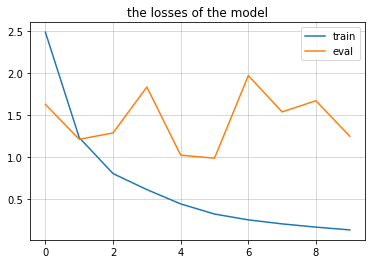

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(eval_losses)), eval_losses), plt.grid(alpha=0.6)
plt.title("the losses of the model")
plt.legend(["train", "eval"])
plt.show()

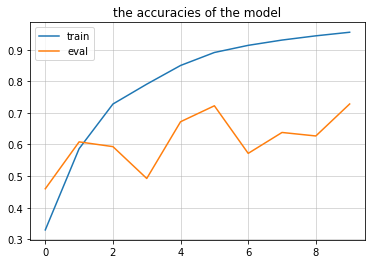

In [ ]:
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(eval_accuracies)), eval_accuracies), plt.grid(alpha=0.6)
plt.title("the accuracies of the model")
plt.legend(["train", "eval"])
plt.show()